## Using `PatternMatch` Action in the `NETWORK` Actionset To Query Airline Routes

------------------------------------------------------------------------------------------------------------------------------

In this Jupyter notebook, we provide an example of using the `PatternMatch` action to search for complex patterns in a graph. Our graph consists of all airports worldwide and the existing air routes between them. We obtain the airlines, airports, routes, and planes datasets from the "openflights.org" website. The code for reading the data as well as the data preparation and cleaning steps, are stored in the "helper.py" script. 

To read more about the `PatternMatch` algorithm, refer to [SAS Documentation](https://go.documentation.sas.com/doc/en/pgmsascdc/default/casactml/cas-network-patternmatch.htm?homeOnFail).  

------------------------------------------------------------------------------------------------------------------------------
The flow of this notebook is as follows:
* [Reading the airports, airlines, routes and planes data from openflights website](#1st-bullet)
* [Visualizing all airports on the world map](#2nd-bullet)
* [Visualize all routes from JFK airport](#3rd-bullet)
* [Connecting to CAS server](#4th-bullet)
* [Uploading links (routes) and nodes(airports) DataFrame to CAS](#5th-bullet)
* [Finding non-stop flights with from RDU to PHX](#6th-bullet)
* [Finding 1-stop or 2-stops flights with American Airlines from RDU to PHX with Boeing737-800](#7th-bullet)
* [Visualizing the results](#8th-bullet)
* [Adding a constraint on the total flight distance](#9th-bullet)
* [Visualizing the results](#10-bullet)
------------------------------------------------------------------------------------------------------------------------------
**Prepared by:** Hossein Tohidi (<i class="fa fa-github" aria-hidden="true"></i> [Hossein-Tohidi](https://github.com/Hossein-Tohidi))



In [1]:
import swat
import pandas as pd
import numpy as np
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()),r"../../common/python"))
import cas_connection as cas 
import requests
import matplotlib.pyplot as plt
%matplotlib notebook  
import matplotlib as mpl
from matplotlib import cm
import geopandas as gpd
import networkx as nx
from shapely.geometry import Polygon
import helper
import random
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

### Reading the airports, airlines, routes and planes data from openflights website <a class="anchor" id="1st-bullet"></a>

In [2]:
airports = helper.read_airports("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat")
airports.head()

,AirportID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz,Type,Source,node,pos
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports,GKA,"(145.391998291, -6.081689834590001)"
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports,MAG,"(145.789001465, -5.20707988739)"
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports,HGU,"(144.29600524902344, -5.826789855957031)"
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports,LAE,"(146.725977, -6.569803)"
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports,POM,"(147.22000122070312, -9.44338035583496)"


In [3]:
airlines = helper.read_airlines("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airlines.dat")
airlines.head()

,Airline ID,Airline Name,Alias,Airline IATA,ICAO,Callsign,Airline Country,Active
1,1,Private flight,\N,-,NaN,NaN,NaN,Y
3,3,1Time Airline,\N,1T,RNX,NEXTIME,South Africa,Y
10,10,40-Mile Air,\N,Q5,MLA,MILE-AIR,United States,Y
13,13,Ansett Australia,\N,AN,AAA,ANSETT,Australia,Y
14,14,Abacus International,\N,1B,NaN,NaN,Singapore,Y


In [4]:
routes = helper.read_routes("https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat",airports,airlines)
routes.head()

,from,Source airport ID,to,Destination airport ID,Codeshare,Equipment,Airline IATA,Airline Name,Airline Country
0,AER,2965,KZN,2990,NaN,CR2,2B,Aerocondor,Portugal
1,ASF,2966,KZN,2990,NaN,CR2,2B,Aerocondor,Portugal
2,ASF,2966,MRV,2962,NaN,CR2,2B,Aerocondor,Portugal
3,CEK,2968,KZN,2990,NaN,CR2,2B,Aerocondor,Portugal
4,CEK,2968,OVB,4078,NaN,CR2,2B,Aerocondor,Portugal


In [5]:
planes = helper.read_planes("https://raw.githubusercontent.com/jpatokal/openflights/master/data/planes.dat")
planes.head()

,Name,Plane IATA,Plane ICAO
0,Aerospatiale (Nord) 262,ND2,N262
1,Aerospatiale (Sud Aviation) Se.210 Caravelle,CRV,S210
2,Aerospatiale SN.601 Corvette,NDC,S601
3,Aerospatiale/Alenia ATR 42-300,AT4,AT43
4,Aerospatiale/Alenia ATR 42-500,AT5,AT45


### Visualizing all airports on the world map <a class="anchor" id="2nd-bullet"></a>

In [6]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


<IPython.core.display.Javascript object>


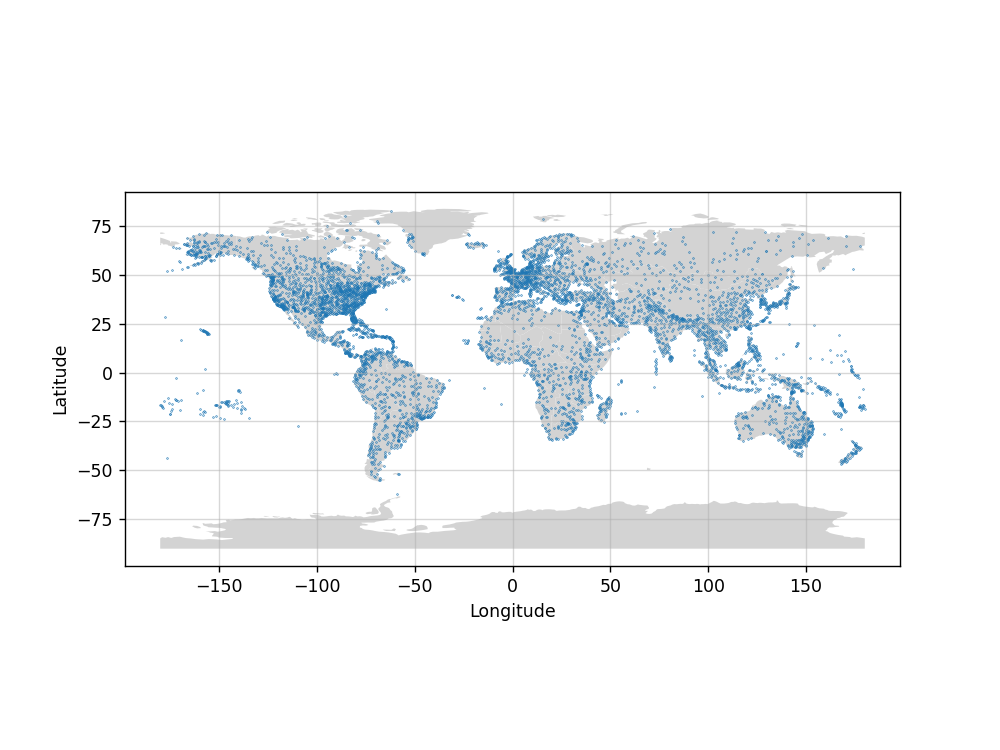

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
countries.plot(color="lightgrey", ax=ax)
airports.plot(x="Longitude", y="Latitude", s=0.1, kind="scatter", ax=ax)
ax.grid(alpha=0.5)
plt.show()

<IPython.core.display.Javascript object>


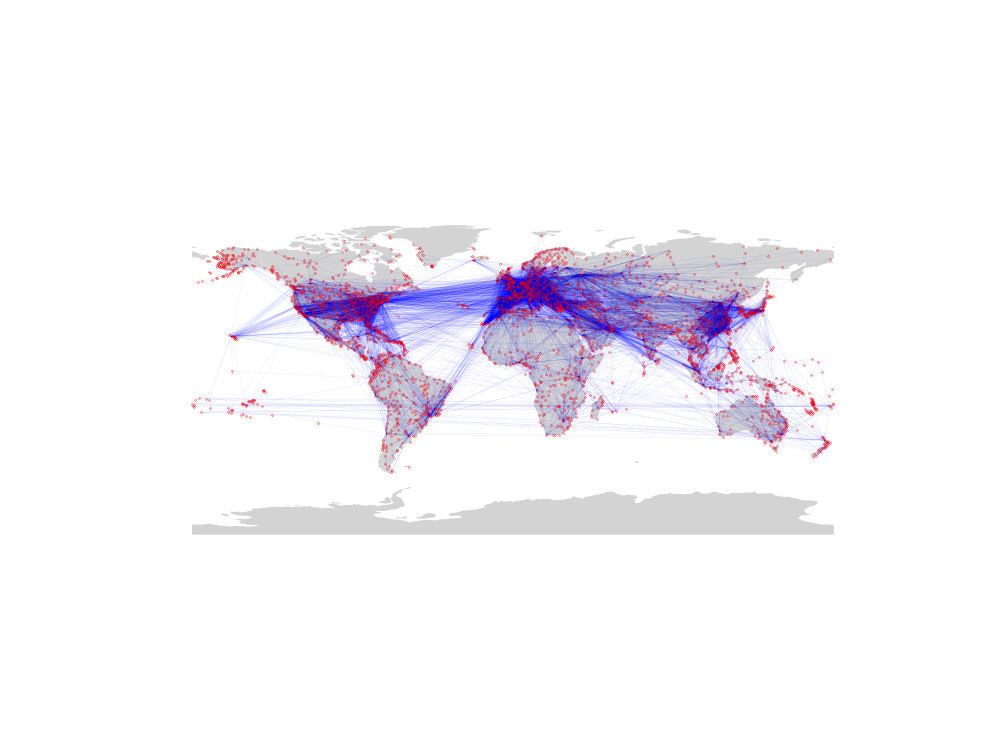

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
G = nx.from_pandas_edgelist(routes, source='from', target='to', create_using=nx.DiGraph())
attrs = airports.set_index('IATA').to_dict('index')
nx.set_node_attributes(G, attrs)
pos = nx.get_node_attributes(G, 'pos')

countries.plot(color="lightgrey", ax=ax)
nx.draw(G, pos, edge_color='blue', node_color='red', width=0.01, node_size=0.05, arrowsize=0.1, ax=ax)
plt.show()

### Visualize all routes from JFK airport <a class="anchor" id="3rd-bullet"></a>

<IPython.core.display.Javascript object>


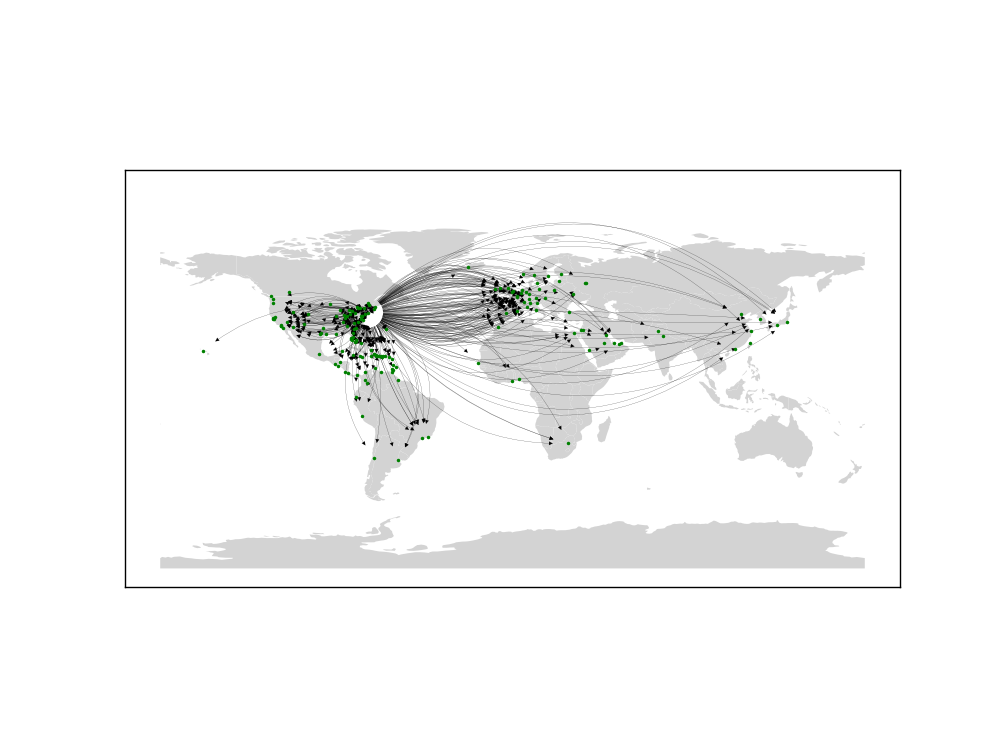

In [9]:
linksDF_filtered = routes[routes['from']=='JFK']
filtered_nodes = ['JFK'] + routes['to'].to_list()
nodesDF_filtered = airports[airports['IATA'].isin(filtered_nodes)]
fig, ax = plt.subplots(figsize=(8,6))
G = nx.from_pandas_edgelist(linksDF_filtered, source='from', target='to',create_using=nx.MultiDiGraph())
attrs = nodesDF_filtered.set_index('IATA').to_dict('index')
nx.set_node_attributes(G, attrs)
pos = nx.get_node_attributes(G, 'pos')

countries.plot(color="lightgrey",ax=ax)

nx.draw_networkx_nodes(G, pos,node_size=1, ax=ax,node_color='green')
for edge in G.edges(data=True):
    nx.draw_networkx_edges(G, pos, 
                           edgelist=[(edge[0],edge[1])], 
                           connectionstyle=f'arc3, rad = {np.random.random()-0.5}', #random edge curve to minimize the edge overlaps
                           width=0.1,
                           arrowsize=5,
                           edge_color={'k'}, ax=ax)
plt.show()    

### Connecting to CAS server <a class="anchor" id="4th-bullet"></a>

In [10]:
s = cas.reconnect()
s.loadActionSet('network')
s.loadActionSet('fedsql')

NOTE: Added action set 'network'.
NOTE: Added action set 'fedsql'.


[actionset]

 'fedsql'

+ Elapsed: 0.00145s, user: 0.00143s, mem: 0.24mb

### Uploading links (routes) and nodes(airports) DataFrame to CAS <a class="anchor" id="5th-bullet"></a>

In [11]:
swat.options.cas.print_messages=False 
s.upload(routes, casout = {'name':'RouteLinks', 'replace':True})
s.upload(airports, casout = {'name':'AirportsNodes', 'replace':True})
swat.options.cas.print_messages=True 

### Finding non-stop flights from RDU to PHX <a class="anchor" id="6th-bullet"></a>

Finding non-stop flights between the two specific airports is not difficult and can be done by using DataFrame conditional selection. 

In [12]:
routes[(routes['from']=='RDU')&(routes['to']=='PHX')]

,from,Source airport ID,to,Destination airport ID,Codeshare,Equipment,Airline IATA,Airline Name,Airline Country
65242,RDU,3626,PHX,3462,NaN,73W,WN,Southwest Airlines,United States


In [13]:
routes.query('`from`=="RDU" & `to`=="PHX"')

,from,Source airport ID,to,Destination airport ID,Codeshare,Equipment,Airline IATA,Airline Name,Airline Country
65242,RDU,3626,PHX,3462,NaN,73W,WN,Southwest Airlines,United States


### Finding 1-stop or 2-stops flights with American Airlines from RDU to PHX with Boeing737-800<a class="anchor" id="7th-bullet"></a>

In [14]:
nodes_query = [['X','RDU'],
               ['Z','PHX']]
links_query = [['X','Y','American Airlines',1     ,2     ], 
               ['Y','Z','American Airlines',np.nan,np.nan]] 
df_nodes_query = pd.DataFrame(nodes_query,columns = ['node','IATA'])
df_links_query = pd.DataFrame(links_query,columns = ['from','to','Airline Name','expandL','expandU'])

s.upload(df_nodes_query,casout = {'name':'NodesQuery','replace':True})
s.upload(df_links_query,casout = {'name':'LinksQuery','replace':True})

NOTE: Cloud Analytic Services made the uploaded file available as table AIRPORTS_QUERY in caslib CASUSER(hotohi).
NOTE: The table AIRPORTS_QUERY has been created in caslib CASUSER(hotohi) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table ROUTE_QUERY in caslib CASUSER(hotohi).
NOTE: The table ROUTE_QUERY has been created in caslib CASUSER(hotohi) from binary data uploaded to Cloud Analytic Services.


[caslib]

 'CASUSER(hotohi)'

[tableName]

 'ROUTE_QUERY'

[casTable]

 CASTable('ROUTE_QUERY', caslib='CASUSER(hotohi)')

+ Elapsed: 0.0205s, user: 0.00299s, sys: 0.000752s, mem: 33.2mb

In [15]:
plane_code = planes.loc[planes['Name']=='Boeing 737-800','Plane IATA'].values[0]
my_filter = f"""
   function myLinkFilter(string $);
      return (find(string,'{plane_code}'));
   endsub; 
"""

In [16]:
result = s.network.patternMatch(
            code          = my_filter,
            logLevel      = "Basic",
            direction     = "directed",
            links         = {"name":"RouteLinks"},
            nodes         = {"name":"AirportsNodes"},
            linksQuery    = {"name":"LinksQuery"},
            nodesQuery    = {"name":"NodesQuery"},
            nodesVar      = {"vars":("IATA","Latitude","Longitude",'City')}, 
            linksVar      = {"vars":("Airline Name","Equipment")}, 
            nodesQueryVar = {"vars":("IATA")},
            linksQueryVar = {"expandLower":"expandL","expandUpper":"expandU","vars":("Airline Name")},            
            linkFilter    = f"myLinkFilter(links.Equipment)",
            outNodes      = {"name":"OutNodes","replace":True},
            outMatchNodes = {"name":"OutMatchNodes","replace":True},
            outMatchLinks = {"name":"OutMatchLinks","replace":True})

NOTE: The number of nodes in the input graph is 6072.
NOTE: The number of links in the input graph is 68521.
NOTE: In query graph expansion, 2 query graphs have been created.
NOTE: Processing pattern matching using 16 threads across 1 machines.
NOTE: The algorithm found 11 matches.
NOTE: Processing the pattern matching query used 0.01 (cpu: 0.01) seconds.


In [17]:
outMatchLinks = s.CASTable('OutMatchLinks').to_frame()
outMatchLinks.head()

,queryKey,match,from,to,Airline Name,Equipment
0,key_0,0.0,RDU,DFW,American Airlines,M83 M80 738
1,key_0,0.0,DFW,PHX,American Airlines,321 738 M80 319 M83 320
2,key_0,1.0,RDU,MIA,American Airlines,738
3,key_0,1.0,MIA,PHX,American Airlines,738
4,key_0,2.0,RDU,ORD,American Airlines,M80 738


In [18]:
outMatchNodes = s.CASTable('OutMatchNodes').to_frame()
outMatchNodes.head()

,queryKey,match,nodeQ,node,IATA,Latitude,Longitude,City
0,key_0,0.0,X,RDU,RDU,35.877602,-78.787498,Raleigh-durham
1,key_0,0.0,Y_0,DFW,DFW,32.896801,-97.038002,Dallas-Fort Worth
2,key_0,0.0,Z,PHX,PHX,33.434299,-112.012001,Phoenix
3,key_0,1.0,X,RDU,RDU,35.877602,-78.787498,Raleigh-durham
4,key_0,1.0,Y_0,MIA,MIA,25.793200,-80.290604,Miami


### Visualizing the results <a class="anchor" id="8th-bullet"></a>

<IPython.core.display.Javascript object>


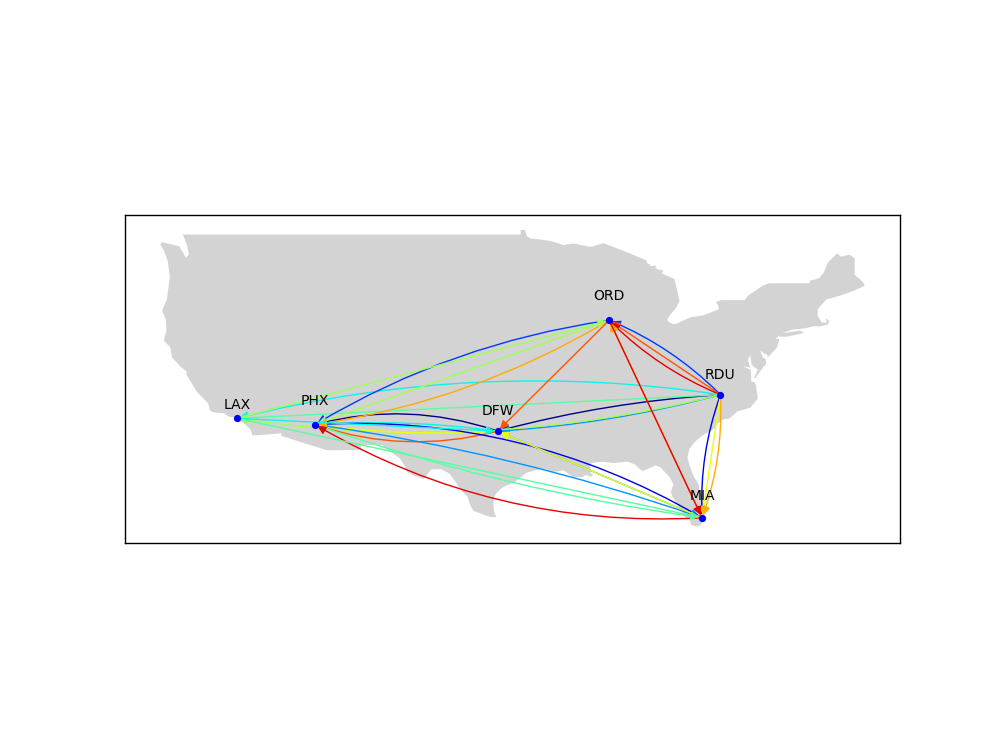

In [19]:
def plot_solution(outMatchNodes,outMatchLinks,result):
    fig, ax = plt.subplots(figsize=(8,6))    
    norm = mpl.colors.Normalize(vmin=0, vmax=result.numMatches)
    m = cm.ScalarMappable(norm=norm, cmap=cm.jet)
    outMatchLinks['match_num'] = outMatchLinks.groupby(['queryKey','match']).ngroup()                           
    outMatchLinks['color'] = [m.to_rgba(i) for i in outMatchLinks['match_num'].values]
    rad_dict = helper.find_radius(outMatchLinks)
    edge_styles = ['-','--',':','-.']
    outMatchLinks['style'] = [edge_styles[i%len(edge_styles)] for i in outMatchLinks['match_num'].values] 
    G = nx.from_pandas_edgelist(outMatchLinks, source='from', target='to',edge_attr=['color','style'],
                                create_using=nx.MultiDiGraph())
    nodesDF_filtered = outMatchNodes[['node','Latitude','Longitude','IATA']] .drop_duplicates(keep='first')
    nodesDF_filtered['pos'] = list(zip(nodesDF_filtered['Longitude'], nodesDF_filtered['Latitude']))
    attrs = nodesDF_filtered.set_index('node').to_dict('index')
    nx.set_node_attributes(G, attrs)
    pos = nx.get_node_attributes(G, 'pos')
    labels = nx.get_node_attributes(G, 'IATA')
    labels_pos = {key:(val[0],val[1]+1+np.random.random()) for key,val in pos.items()}
    #removing Alaska
    mplg = countries.loc[countries["name"] == "United States of America",'geometry'] #MULTIPOLYGON 
    mplg.intersection(Polygon([[-125,20],[-125,50],[-60,50],[-60,20]])).plot(color="lightgrey",ax=ax)
    nx.draw_networkx_labels(G,labels_pos, font_size=8, labels=labels)
    nx.draw_networkx_nodes(G, pos,node_size=10, ax=ax,node_color='blue')
    for edge in G.edges(data=True):
        nx.draw_networkx_edges(G, pos,
                               edgelist=[(edge[0],edge[1])], 
                               connectionstyle=f'arc3, rad = {rad_dict[(edge[0],edge[1])][-1]}', 
                               edge_color={edge[2]['color']},
                               node_size=10,
                               #style=edge[2]['style'],
                               width=0.8,
                               ax=ax)
        rad_dict[(edge[0],edge[1])].pop()
    plt.show()
    
plot_solution(outMatchNodes,outMatchLinks,result)    

### Adding a constraint on the total flight distance <a class="anchor" id="9th-bullet"></a>

Adding 1 or 2 stops to the route should not add more than 40% of the flight distance between RDU and PHX.

In [20]:
lon1,lat1 = airports.loc[airports['IATA']=='RDU',['Longitude','Latitude']].values[0]
lon2,lat2 = airports.loc[airports['IATA']=='PHX',['Longitude','Latitude']].values[0]
gc = helper.find_great_circle_distance(lon1,lat1,lon2,lat2)
print(f'distance between RDU and PHX is {gc:.2f} km')

distance between RDU and PHX is 3037.44 km


In [21]:
# join airports lon-lat to route
result = s.fedSql.execDirect(query='''
                        create table RoutesMerged {options replace=True}  as
                        select routes.*,airports.longitude as fromLon,airports.latitude as fromLat,
                        airports2.longitude as toLon,airports2.latitude as toLat
                        from RouteLinks as routes inner join AirportsNodes as airports
                        on routes.from = airports.IATA
                        inner join AirportsNodes as airports2
                        on routes.to = airports2.IATA ;''')
s.CASTable('RoutesMerged').head()

NOTE: Table ROUTES_MERGED was created in caslib CASUSER(hotohi) with 68521 rows returned.


,from,Source airport ID,to,Destination airport ID,Codeshare,Equipment,Airline IATA,Airline Name,Airline Country,FROMLON,FROMLAT,TOLON,TOLAT
0,LAD,951,SPP,953,,73G,DT,TAAG Angola Airlines,Angola,13.2312,-8.85837,17.719801,-14.657600
1,LAD,951,SVP,949,,73G,DT,TAAG Angola Airlines,Angola,13.2312,-8.85837,16.947399,-12.404600
2,LAD,951,SZA,958,,732 73G,DT,TAAG Angola Airlines,Angola,13.2312,-8.85837,12.371800,-6.141090
3,LAD,951,TMS,973,,73G,DT,TAAG Angola Airlines,Angola,13.2312,-8.85837,6.712150,0.378175
4,LAD,951,VHC,957,,73G 732,DT,TAAG Angola Airlines,Angola,13.2312,-8.85837,20.431900,-9.689070


In [22]:
my_filter = f"""
   function myLinkFilter(string $);
       return (find(string,'{plane_code}'));
   endsub;
   function myMatchFilter(fromLon[*], fromLat[*], toLon[*], toLat[*], threshold);
       total_distance = 0;
       nLinks = dim(fromLon);
       do i = 1 to nLinks;
           distance = geodist(fromLat[i], fromLon[i], toLat[i], toLon[i], 'KD');
           total_distance = total_distance + distance;
       end;
   return (total_distance < threshold);
   endsub;      
"""

In [23]:
result = s.network.patternMatch(
                code           = my_filter,
                logLevel       = "AGGRESSIVE",
                direction      = "directed",
                links          = {"name":"RoutesMerged"},
                nodes          = {"name":"AirportsNodes"},
                linksQuery     = {"name":"LinksQuery"},
                nodesQuery     = {"name":"NodesQuery"},
                nodesVar       = {"vars":("IATA","Latitude","Longitude",'City')}, 
                linksVar       = {"vars":("Airline Name","Equipment","FROMLON","toLon","fromLat","toLat")}, 
                nodesQueryVar  = {"vars":("IATA")},
                linksQueryVar  = {"expandLower":"expandL","expandUpper":"expandU","vars":("Airline Name")},
                linkFilter     = f'myLinkFilter(links.Equipment)',
                matchFilter    = f'myMatchFilter(links.FROMLON,links.fromLat,links.toLon,links.toLat,{1.4*gc})',
                outNodes       = {"name":"OutNodes","replace":True},
                outMatchNodes  = {"name":"OutMatchNodes","replace":True},
                outMatchLinks  = {"name":"OutMatchLinks","replace":True})

NOTE: Reading the nodes data.
NOTE: Reading the links data.
NOTE: Data input used 0.02 (cpu: 0.03) seconds.
NOTE: Building the input graph storage used 0.03 (cpu: 0.02) seconds.
NOTE: The number of nodes in the input graph is 6072.
NOTE: The number of links in the input graph is 68521.
NOTE: In query graph expansion, 2 query graphs have been created.
NOTE: Processing pattern matching using 16 threads across 1 machines.
                                                       Real
         Algorithm              Queries   Complete     Time
         patternMatch                 2       100%     0.01
NOTE: The algorithm found 3 matches.
NOTE: Processing the pattern matching query used 0.01 (cpu: 0.01) seconds.


In [24]:
outMatchLinks = s.CASTable('OutMatchLinks').to_frame()
outMatchLinks

,queryKey,match,from,to,Airline Name,Equipment,FROMLON,TOLON,FROMLAT,TOLAT
0,key_0,0.0,RDU,DFW,American Airlines,M83 M80 738,-78.787498,-97.038002,35.877602,32.896801
1,key_0,0.0,DFW,PHX,American Airlines,321 738 M80 319 M83 320,-97.038002,-112.012001,32.896801,33.434299
2,key_0,1.0,RDU,ORD,American Airlines,M80 738,-78.787498,-87.904800,35.877602,41.978600
3,key_0,1.0,ORD,PHX,American Airlines,321 738 M83 320 M80,-87.904800,-112.012001,41.978600,33.434299
4,key_1,0.0,RDU,ORD,American Airlines,M80 738,-78.787498,-87.904800,35.877602,41.978600
5,key_1,0.0,ORD,DFW,American Airlines,M80 M83 738,-87.904800,-97.038002,41.978600,32.896801
6,key_1,0.0,DFW,PHX,American Airlines,321 738 M80 319 M83 320,-97.038002,-112.012001,32.896801,33.434299


In [25]:
outMatchNodes = s.CASTable('OutMatchNodes').to_frame()
outMatchNodes

,queryKey,match,nodeQ,node,IATA,Latitude,Longitude,City
0,key_0,0.0,X,RDU,RDU,35.877602,-78.787498,Raleigh-durham
1,key_0,0.0,Y_0,DFW,DFW,32.896801,-97.038002,Dallas-Fort Worth
2,key_0,0.0,Z,PHX,PHX,33.434299,-112.012001,Phoenix
3,key_0,1.0,X,RDU,RDU,35.877602,-78.787498,Raleigh-durham
4,key_0,1.0,Y_0,ORD,ORD,41.978600,-87.904800,Chicago
5,key_0,1.0,Z,PHX,PHX,33.434299,-112.012001,Phoenix
6,key_1,0.0,X,RDU,RDU,35.877602,-78.787498,Raleigh-durham
7,key_1,0.0,Y_1,DFW,DFW,32.896801,-97.038002,Dallas-Fort Worth
8,key_1,0.0,Z,PHX,PHX,33.434299,-112.012001,Phoenix
9,key_1,0.0,Y_0,ORD,ORD,41.978600,-87.904800,Chicago


### Visualizing the results <a class="anchor" id="10th-bullet"></a>

<IPython.core.display.Javascript object>


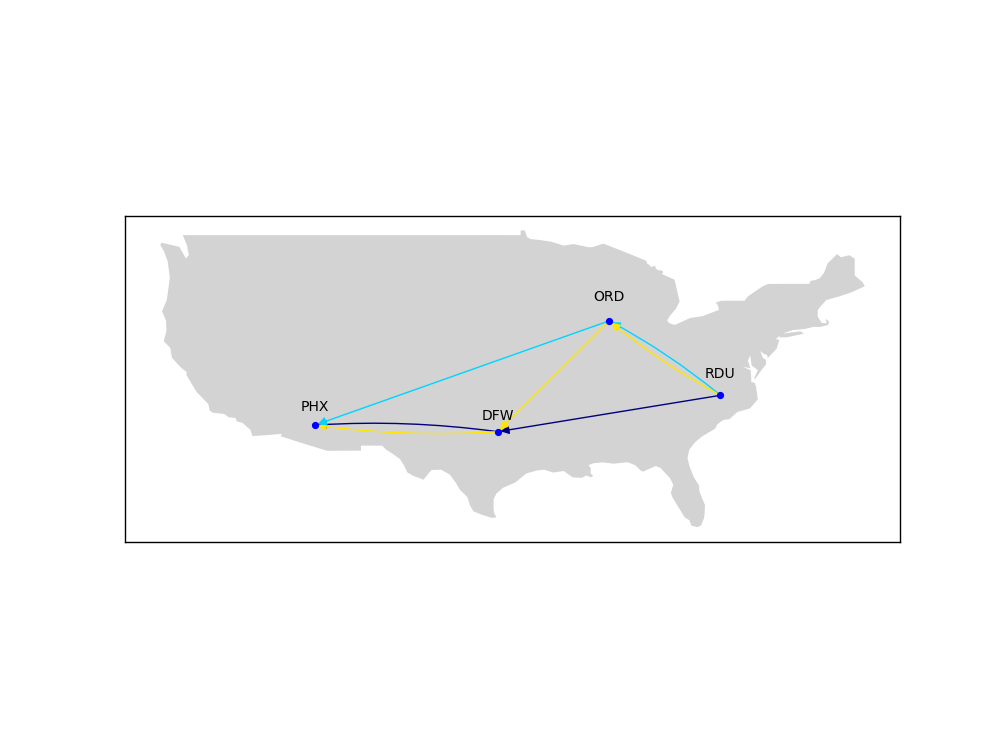

In [26]:
plot_solution(outMatchNodes,outMatchLinks,result)    